# TradeAide: SVM and Random Forest

SVM and RF were two algorithms which we found performed very well for stock prediction in our research. We will see that our results for these algorithms is mostly consistent with our research, but with notable issues that would prevent us from deploying these in the real world. Notably, the predicted stock values are very close in range and will follow the general shape of the curve formed by the actual data, but they are just not accurate enough to feel confident in putting money on the line.

We will see that one potential issue is that our testing data is also newer data, and this stock data usually looks vastly different from the previous data, with significantly higher highs and more volatility, likely attributed to a fluctuating economy, especially with recent data (2020-ish).

### Import libraries

In [1]:
import warnings
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

### Tickers

We used the following tickers in our stock prediction:

- AAPL : Apple
- TSLA : Tesla
- JNJ : Johnson & Johnson

Our choice of tickers was mostly arbitrary, with the primary intent being to get a wide representation of different industries when analyzing our models' performance.

Also observe that we have elected to drop stock data from after October 2019. This is due to the unpredictability of more recent data. Unfortunately, the previous data doesn't resemble newer data (at least for some tickers), which means our model simply didn't generalize well enough. We were able to significantly improve performance by considering a subset of our data. A more sophisticated model could likely overcome these shortcomings, but for now we are considering that to fall under 'future work.'

In [2]:
tickers = ['AAPL', 'TSLA', 'JNJ']

In [3]:
ticker = 'AAPL'

df = pd.read_csv('./data_clean/' + ticker + '.csv')
df = df.sort_values('date')
df = df.drop(['open','high','low','close','volume'], axis=1)

df = df.query('date <= "2019-10-01"')
df = df.reset_index(drop=True)

In [4]:
df['avg_close'] = 0.0
df['sentiment'] = 0.0
df['volatility'] = 0.0

### Create average close price feature
Average is based on [up to] the previous 5 days, not including the current day, which is essential because we don't want our model to be predicting stock data for future days since this would cause two things:

1. Overfitting of model to test data
2. Inaccurate predictions

In [5]:
days = 5

for i, _ in df.iterrows():
    if i:
        df['avg_close'][i] = sum(df['adj close'][i - k] for k in range(1, i + 1 if i < (days + 1) else (days + 1))) / (i if i < (days + 1) else days)
    if i > 1:
        df['volatility'][i] = df['adj close'][i - 1] / df['adj close'][i - 2]

### Add sentiment feature

Note that the sentiments were pre-computed and stored in a CSV. The sentiments were based on news articles which had associating stock tickers and dates. We cover a running period of [up to] 5 days and take the average sentiment across those days.

The actual sentiment value is a weighted average of the sentiment of the news headline as well as the actual text of the article. These values are pre-scaled.

Note that we actually observe a drop in performance due to this feature. One possible explanation being that these articles are written by individuals with human bias that doesn't accurately reflect the actual market's perception of that company. This theory was corroborated by Daniel's financial mentor. We wouldn't preferred to use Tweet data, but Twitter's data collection policy changes prevented this at the time of this project. 

In [6]:
sent_df = pd.read_csv('news_sentiments.csv')
sent_df = sent_df.loc[sent_df['ticker'] == ticker]

In [7]:
for i, _ in df.iterrows():
    s = sent_df.loc[sent_df['release_date'] == df['date'][i]]['sentiment']
    df['sentiment'][i] = s.iloc[0] if len(s) else 0.0

In [8]:
for i, _ in df.iterrows():
    s = df['date'][i]
    e = datetime.datetime.strptime(s, "%Y-%m-%d").date() - datetime.timedelta(days=7)
    sent = sent_df.query('release_date < "' + s + '" and release_date >= "' + e.strftime("%Y-%m-%d") + '"')
    df['sentiment'][i] = (sum(sent['sentiment']) / len(sent)) if len(sent) else 0.0
    df['sentiment'][i] = 1.0 if df['sentiment'][i] > 0 else -1.0

### Check data

We check our data stock data with computed features

In [9]:
df.head(n=15)

,date,adj close,avg_close,sentiment,volatility
0,2015-01-02,100.216454,0.000000,1.0,0.000000
1,2015-01-05,97.393181,100.216454,1.0,0.000000
2,2015-01-06,97.402374,98.804817,1.0,0.971828
3,2015-01-07,98.768150,98.337336,1.0,1.000094
4,2015-01-08,102.563072,98.445040,1.0,1.014022
5,2015-01-09,102.673050,99.268646,1.0,1.038423
6,2015-01-12,100.143120,99.759966,1.0,1.001072
7,2015-01-13,101.032280,100.309953,1.0,0.975359
8,2015-01-14,100.647285,101.035934,1.0,1.008879
9,2015-01-15,97.915672,101.411761,-1.0,0.996189


Just for kicks, let's see what our sentiment data looks like for reference

In [10]:
sent_df.head(n=15)

,id,release_date,ticker,sentiment
44463,270698,2020-01-28,AAPL,0.323871
44464,270699,2020-01-28,AAPL,0.974808
44465,270700,2020-01-28,AAPL,-0.660437
44466,270701,2020-01-28,AAPL,-0.120343
44467,270702,2020-01-28,AAPL,1.043182
44468,270703,2020-01-28,AAPL,-0.412607
44469,270704,2020-01-28,AAPL,0.244202
44470,270705,2020-01-28,AAPL,-1.589824
44471,270706,2020-01-28,AAPL,-0.157967
44472,270707,2020-01-28,AAPL,-0.330451


In [11]:
df.describe()

,adj close,avg_close,sentiment,volatility
count,1195.000000,1195.000000,1195.000000,1195.000000
mean,143.408894,143.019632,0.668619,0.999120
std,39.443615,39.452426,0.743916,0.043875
min,85.192909,0.000000,-1.000000,0.000000
25%,107.230064,107.234058,1.000000,0.993897
50%,139.753540,139.113126,1.000000,1.000626
75%,173.280235,172.537166,1.000000,1.008749
max,227.300339,223.772369,1.000000,1.070422


In [12]:
sent_df.describe()

,id,sentiment
count,18776.000000,18776.000000
mean,280178.271251,0.158211
std,5533.227834,1.101639
min,270698.000000,-21.814174
25%,275391.750000,-0.169260
50%,280085.500000,0.019014
75%,285087.250000,0.236018
max,289790.000000,34.283569


In [13]:
print('Dimension of stock data:', df.shape)
print('Dimension of sentiment data:', sent_df.shape)

Dimension of stock data: (1195, 5)
Dimension of sentiment data: (18776, 4)


### Plot Data

Visualizing our stock data is a key component of our project. We usually expect to see graphs like the one below to get an idea of what our stock's movement has been over a period of time.

Later on, we will also want to superimpose our predicted values on the corresponding portion of our plot. For now, this helper function will allow us to plot an arbitrary number of datasets on the same plot, including for unpredicted stock data.

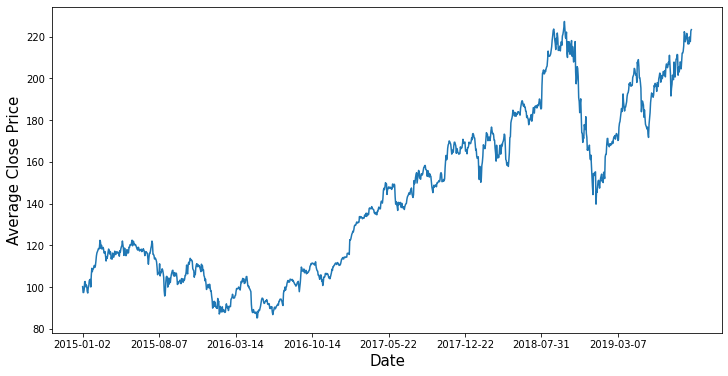

In [14]:
"""
Plot stock datasets. Multiple datasets can be passed in which will be superimposed on top of each other.

args:
    - data: Stock data to plot
    - dates: Date strings to plot on x-axis
    - xticks: Scaling factor for dates
    - legend: Flag to toggle legend
"""
def plotStocks(data, dates, xticks, legend=False):
    plt.figure(figsize=(12,6))
    for datum in data:
        plt.plot(datum[0], datum[1], **datum[2])
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Average Close Price', fontsize=15)
    plt.xticks(np.arange(0, len(dates), xticks))
    plt.legend() if legend else None
    plt.show()

stock_data = [(df['date'], df['adj close'], {})]
plotStocks(stock_data, df['date'], 150)

### Create feature set and target vector

In [15]:
X = df.drop(labels=['adj close'], axis=1)
y = df['adj close']

print('Dimension of feature matrix:', X.shape)
print('Dimension of target vector:', y.shape)

Dimension of feature matrix: (1195, 4)
Dimension of target vector: (1195,)


### Create test and train datasets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

dates = X_test['date']

X_train = X_train.drop(labels=['date'], axis=1)
X_test = X_test.drop(labels=['date'], axis=1)

Because we want to run multiple models across multiple tickers, we're going to start creating functions to assist in adding our features and creating the test/training datasets for us. We also need to read in data for an arbitrary company with the corresponding sentiments.

In [17]:
"""
Add running average of adjusted close price.

args:
    - days: Number of days to take running average (up to)
"""
def addAvgClose(df, days=5):
    df['avg_close'] = 0.0

    for i, _ in df.iterrows():
        if i:
            df['avg_close'][i] = sum(df['adj close'][i - k] for k in range(1, i + 1 if i < (days + 1) else (days + 1))) / (i if i < (days + 1) else days)

"""
Add volatility feature. This is simply the ratio of the previous two days' adjusted close price.
Note:
>1 -> increasing
<1 -> decreasing
0  -> unchanging

args:
    - df: DataFrame of stock data
"""
def addVolatility(df):
    df['volatility'] = 0.0
    
    for i, _ in df.iterrows():
        if i > 1:
            df['volatility'][i] = df['adj close'][i - 1] / df['adj close'][i - 2]

"""
Add running average of sentiment for a given company ticker. We read in from a CSV of pre-computed sentiments of news
headlines and articles and take the running average for a number of days.

args:
    - df: DataFrame of stock data
    - ticker: Company ticker to pull sentiments for
    - days: Number of running days to take average
"""
def addSentiment(df, ticker, days=5):
    df['sentiment'] = 0.0
            
    sent_df = pd.read_csv('news_sentiments.csv')
    sent_df = sent_df.loc[sent_df['ticker'] == ticker]
    
    for i, _ in df.iterrows():
        s = df['date'][i]
        e = datetime.datetime.strptime(s, "%Y-%m-%d").date() - datetime.timedelta(days=days)
        sent = sent_df.query('release_date < "' + s + '" and release_date >= "' + e.strftime("%Y-%m-%d") + '"')
        df['sentiment'][i] = (sum(sent['sentiment']) / len(sent)) if len(sent) else 0.0
        df['sentiment'][i] = 1.0 if df['sentiment'][i] > 0 else -1.0

"""
Add desired features to stock data and plot data for visualization

args:
    - df: DataFrame of stock data
    - ticker: Company ticker
"""
def addFeaturesAndPlotData(df, ticker):
    addAvgClose(df)
    addVolatility(df)
    addSentiment(df, ticker)
        
    stock_data = [(df['date'], df['adj close'], {})]
    plotStocks(stock_data, df['date'], 150)

"""
Gets training and test datasets as well as dates vector for data visualization. Dataframes returned and ready to be
passed to desired model.

args:
    - df: DataFrame of stock data
"""
def getTestAndTrain(df):
    X = df.drop(labels=['adj close'], axis=1)
    y = df['adj close']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    dates = X_test['date']

    X_train = X_train.drop(labels=['date'], axis=1)
    X_test = X_test.drop(labels=['date'], axis=1)
    
    return X_train, y_train, X_test, y_test, dates

"""
Reads in data for a given company's stock ticker and performs a cutoff for improved performance.

args:
    - ticker: Company ticker to read in stock data
    - cutoff: Date to cutoff stock data (deletes data after this date)
"""
def readData(ticker, cutoff='2019-10-01'):
    df = pd.read_csv('./data_clean/' + ticker + '.csv')
    df = df.sort_values('date')
    df = df.drop(['open','high','low','close','volume'], axis=1)

    if cutoff:
        df = df.query('date <= "' + cutoff + '"')
        df = df.reset_index(drop=True)
        
    return df

### Evaluate Model

We use MSE and MAE as evaluation metrics. We also want to write functions which superimpose our predicted stocks on the actual values since this is the most fundamental visualization we have to analyze our model's performance.

In [18]:
"""
Prints the entire global stock data (including traning data), with the predicted stock values superimposed on top.

args:
    - df: DataFrame of stock data (entire history)
    - dates: Date strings for x-axis
    - y_pred: Predicted stock values
"""
def printGlobalStockRes(df, dates, y_pred):
    stock_data = [(df['date'], df['adj close'], {'color': 'green', 'label': 'Data'}),
                  (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
    plotStocks(stock_data, df['date'], 150, True)

"""
Prints only the predicted stock values with the actual stock values corresponding to that same range of time (doesn't
include traning data)

args:
    - dates: Date strings for x-axis
    - y_test: Actual stock values
    - y_pred: Predicted stock values
"""
def printLocalStockRes(dates, y_test, y_pred):
    stock_data = [(dates, y_test, {'color': 'green', 'label': 'Data'}),
                  (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
    plotStocks(stock_data, dates, 50, True)

"""
Mean squared error evaluation metric.

args:
    - y_test: Actual stock values
    - y_pred: Predicted stock values
"""
def MSE(y_test, y_pred):
    err = mean_squared_error(y_test, y_pred)
    print('MSE:', err)

"""
Mean absolute error evaluation metric.

args:
    - y_test: Actual stock values
    - y_pred: Predicted stock values
"""
def MAE(y_test, y_pred):
    err = mean_absolute_error(y_test, y_pred)
    print('MAE:', err)

# Train Models

#### SVM regression

In [19]:
"""
Returns the confidence for SVM.

args:
    - svr: Trained model
    - X_test: Actual stock test data
    - y_test: Actual stock test labels
"""
def SVMConfidence(svr, X_test, y_test):
    svm_confidence = svr.score(X_test, y_test)
    print('SVM Confidence:', svm_confidence)

"""
Runs model selection (hyperparameter tuning) for SVM.

args:
    - ticker: Company to predict stock values for
"""
def runSVMModelSelection(ticker):
    df = readData(ticker)
    addFeaturesAndPlotData(df, ticker)
    X_train, y_train, X_test, y_test, dates = getTestAndTrain(df)
    
    param_grid = {'kernel': ('linear','poly','rbf','sigmoid'),
                  'C': [1,5,10],
                  'degree': [3,8],
                  'coef0': [0.01,10,0.5],
                  'gamma': ('auto','scale')}
    svr = SVR()
    grids = GridSearchCV(svr, param_grid, cv=ShuffleSplit(test_size=0.20, n_splits=1), verbose=10)
    grids.fit(X_train, y_train)
    params_optimal = grids.best_params_

    svr = SVR(params_optimal)
    y_pred = svr.fit(X_train, y_train).predict(X_test)

"""
Trains SVM model.

args:
    - ticker: Company to predict stock values for
"""
def runSVM(ticker):
    print('SVM –', ticker)
    
    df = readData(ticker)
    addFeaturesAndPlotData(df, ticker)
    X_train, y_train, X_test, y_test, dates = getTestAndTrain(df)

    svr = SVR(kernel='linear')
    y_pred = svr.fit(X_train, y_train).predict(X_test)
    
    SVMConfidence(svr, X_test, y_test)
    
    printGlobalStockRes(df, dates, y_pred)
    printLocalStockRes(dates, y_test, y_pred)
    
    MSE(y_test, y_pred)
    MAE(y_test, y_pred)

#### Random Forests regression

In [20]:
"""
Trains RF model.

args:
    - ticker: Company to predict stock values for
"""
def runRandomForest(ticker):
    print('Random Forest –', ticker)
    
    df = readData(ticker)
    addFeaturesAndPlotData(df, ticker)
    X_train, y_train, X_test, y_test, dates = getTestAndTrain(df)
    
    reg = RandomForestRegressor()
    y_pred = reg.fit(X_train, y_train).predict(X_test)
    
    printGlobalStockRes(df, dates, y_pred)
    printLocalStockRes(dates, y_test, y_pred)
    
    MSE(y_test, y_pred)
    MAE(y_test, y_pred)

### Results

Here, we run SVM and RF for AAPL, TSLA, and JNJ and observe the results. Each run will print the model used as well as the stock ticker, and display 3 graphs:

1. Full stock data used across training and test data
2. Full stock data with predicted data superimposed on corresponding portion
3. Zoomed in on superimposed predicted data

The runs which use SVM will also print the SVM confidence. Finally, we print the results from our metrics: MSE and MAE.

Note that none of these runs use model selection due to training time constraints, though this could easily be enabled by a function parameter for [theoretically] better results.

SVM – AAPL


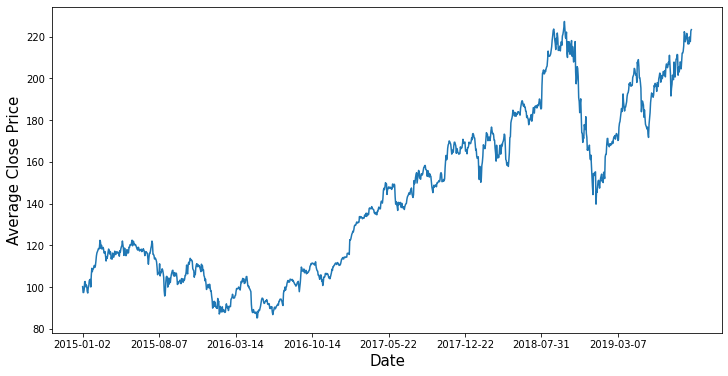

SVM Confidence: 0.9374643606683599


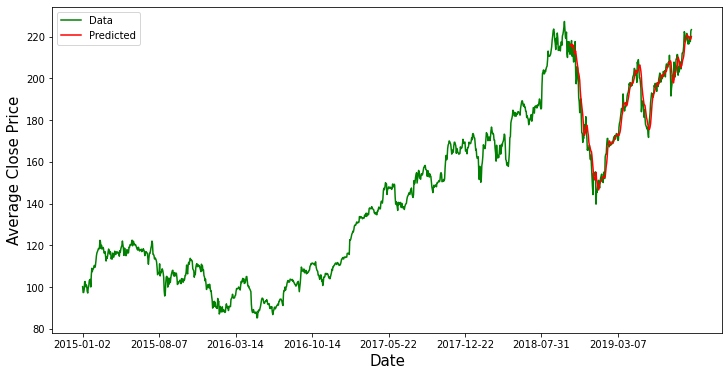

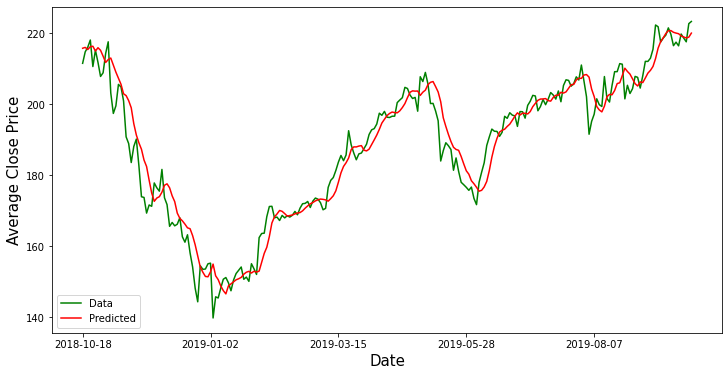

MSE: 25.767292011013136
MAE: 3.8135150794897315


In [21]:
runSVM('AAPL')

Random Forest – AAPL


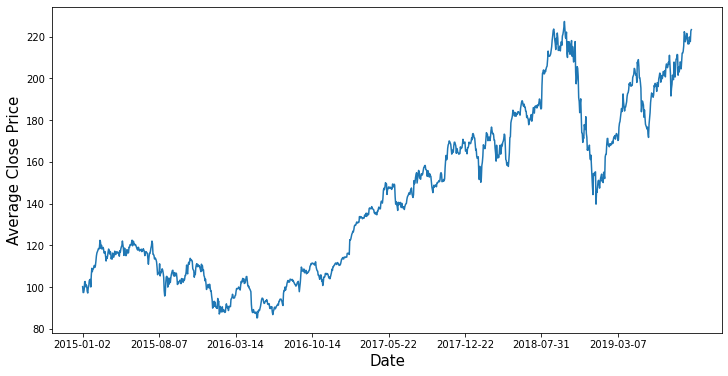

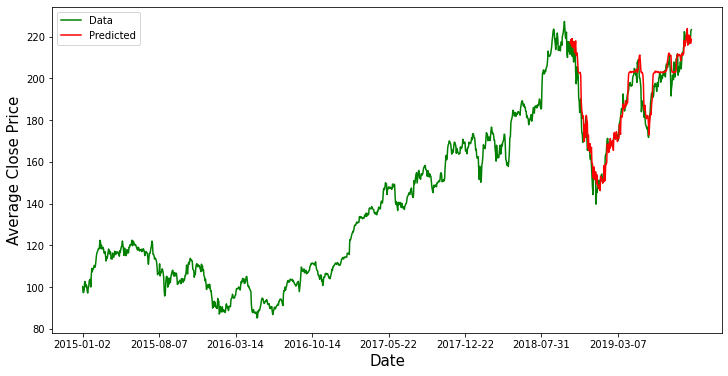

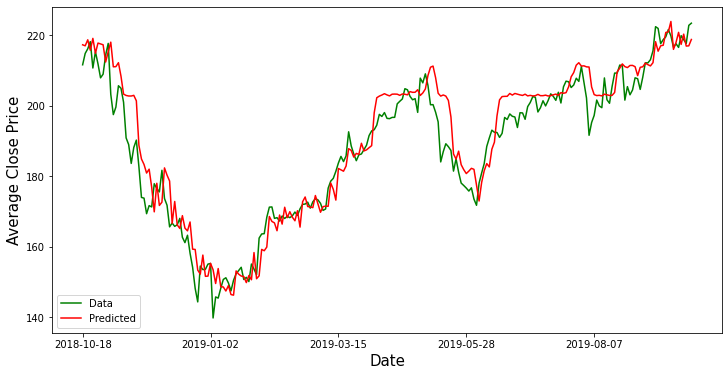

MSE: 36.3031553076786
MAE: 4.610267819839542


In [22]:
runRandomForest('AAPL')

SVM – TSLA


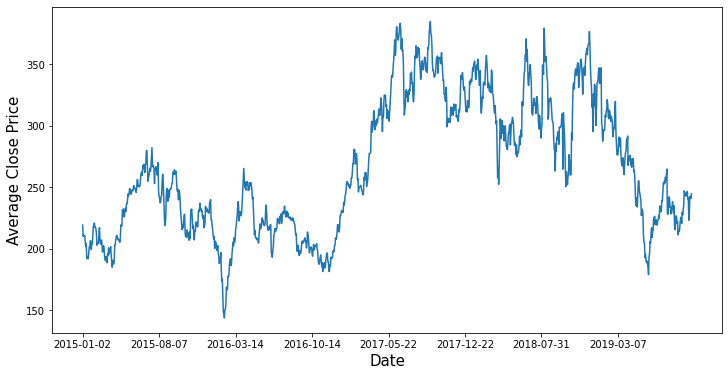

SVM Confidence: 0.9314679290842687


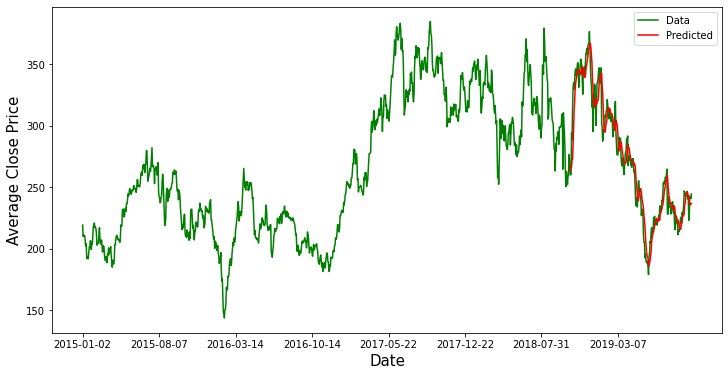

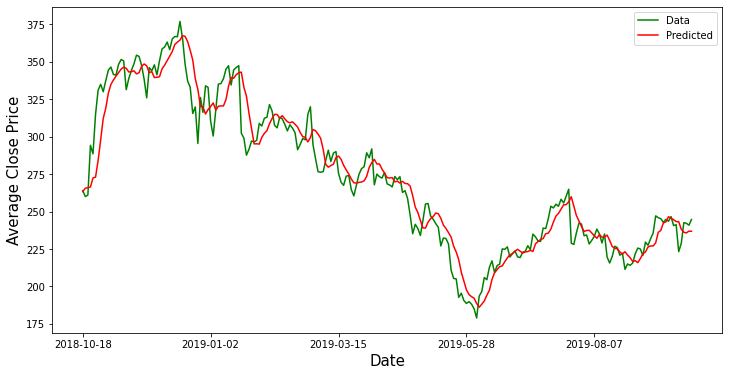

MSE: 162.74451524872987
MAE: 9.461893688830667


In [23]:
runSVM('TSLA')

Random Forest – TSLA


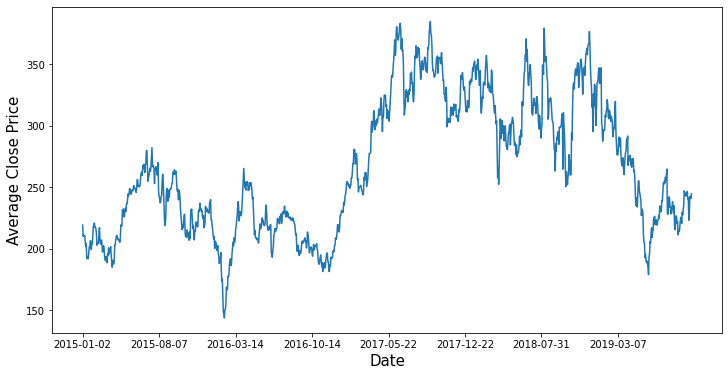

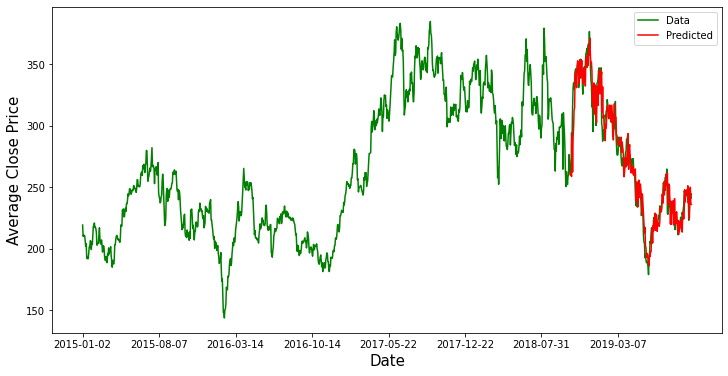

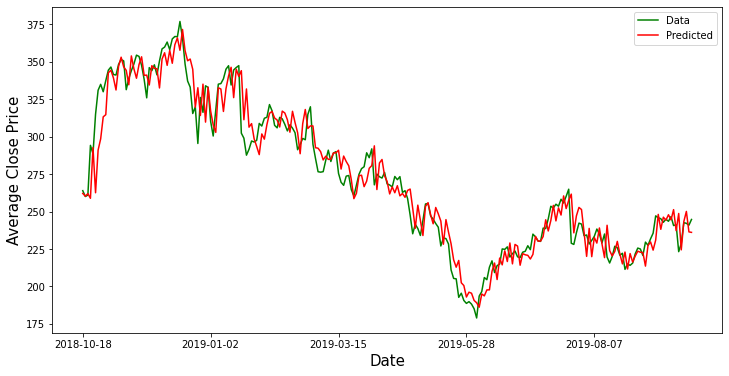

MSE: 149.8844494849794
MAE: 8.97418823306032


In [24]:
runRandomForest('TSLA')

SVM – JNJ


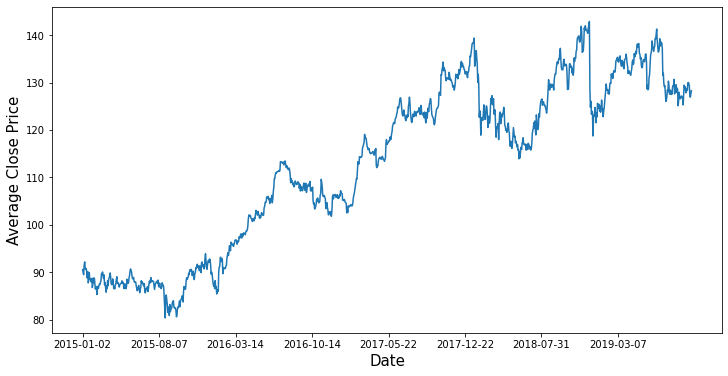

SVM Confidence: 0.7703799773805675


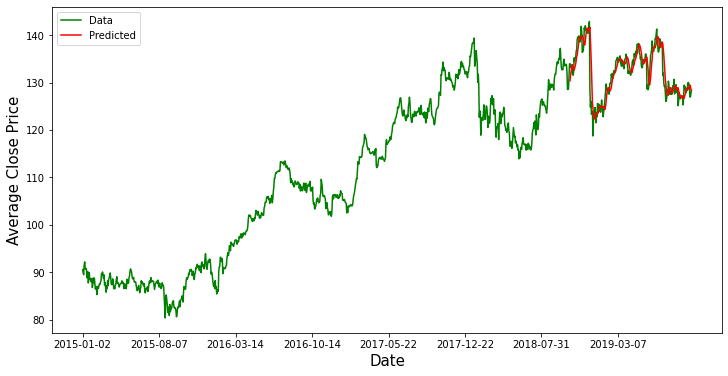

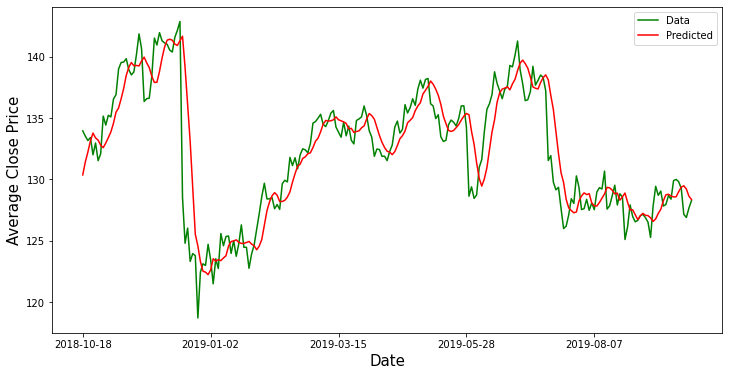

MSE: 6.030116474082952
MAE: 1.6297346221982478


In [25]:
runSVM('JNJ')

Random Forest – JNJ


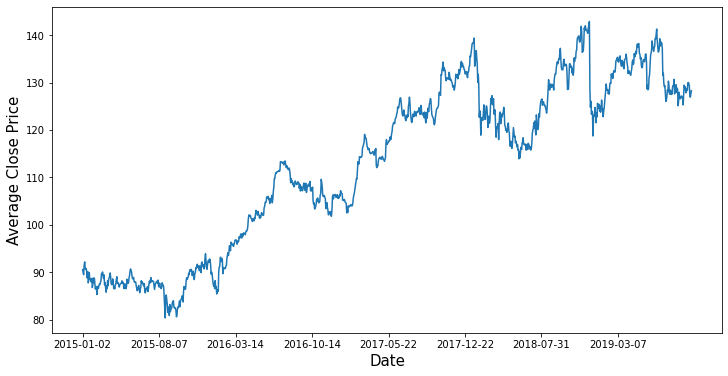

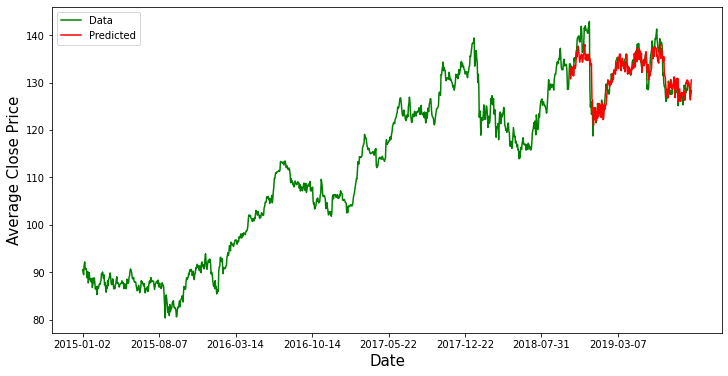

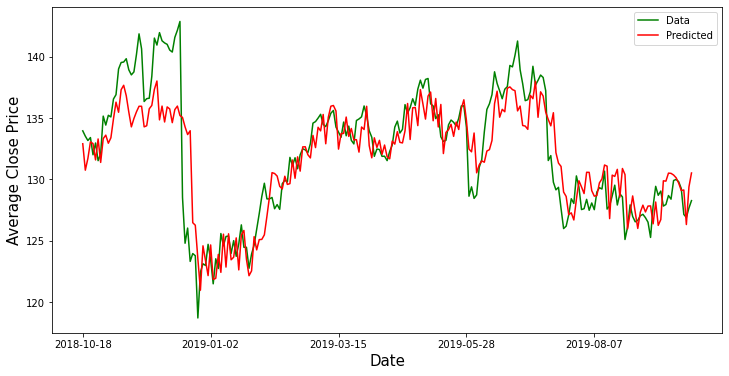

MSE: 6.585007199940156
MAE: 1.9112301428248217


In [26]:
runRandomForest('JNJ')

### Incremental training

Incremental training is a way of testing our training data where we incrementally train a new model to contain every new actual datum (i.e., every day we get a new instance of that day's stock data) in order to get a sense for how our model would perform if actually deployed.

In [27]:
# reg = RandomForestRegressor()

# n = len(X_test)
# to_pred = pd.DataFrame(data=[[0,0.0,0.0]], columns=['sentiment', 'avg_close'])
# y_pred = np.array([])

# data = X_train.copy(deep=True)
# prices = y_train.copy(deep=True).to_numpy()

# def prepNextInstance(to_pred, prices, l):
#     to_pred['sentiment'][0] = 1 if prices[l - 1] > prices[l - 2] else -1
#     to_pred['avg_close'][0] = prices[l - 1] / prices[l - 2]
#     to_pred['avg_close'][0] = sum(prices[i] for i in range(l - 5, l)) / 5

# for _ in range(n):
#     prepNextInstance(to_pred, prices, len(prices))
#     val = reg.fit(data, prices).predict(to_pred)
#     data = data.append(to_pred)
#     y_pred = np.append(y_pred, val)
#     prices = np.append(prices, val)

In [28]:
# stock_data = [(dates, y_test, {'color': 'green', 'label': 'Data'}),
#               (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
# plotStocks(stock_data, dates, 50, True)